In [2]:
# to prevent unnecessary warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess
import cv2
import json
import requests
from tqdm import tqdm

print(tf.__version__)

2.8.2


In [3]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print('\nTrain_images.shape: {}, of {}'.format(train_images.shape, train_images.dtype))
print('Test_images.shape: {}, of {}'.format(test_images.shape, test_images.dtype))

4431872/4422102 [==============================] - 0s 0us/step

Train_images.shape: (60000, 28, 28), of uint8
Test_images.shape: (10000, 28, 28), of uint8


#Reshape data

In [4]:
train_images_3ch = np.stack([train_images]*3, axis=-1)
test_images_3ch = np.stack([test_images]*3, axis=-1)

print('\nTrain_images.shape: {}, of {}'.format(train_images_3ch.shape, train_images_3ch.dtype))
print('Test_images.shape: {}, of {}'.format(test_images_3ch.shape, test_images_3ch.dtype))

#imagenet competition was for colored images hence 3 channels


Train_images.shape: (60000, 28, 28, 3), of uint8
Test_images.shape: (10000, 28, 28, 3), of uint8


#Resizing image

###The minimum image size expected by the VGG model is 32x32 so we need to resize our images

In [5]:
import cv2

def resize_image_array(img, img_size_dims):
    img = cv2.resize(img, dsize=img_size_dims, 
    interpolation=cv2.INTER_CUBIC)
    img = np.array(img, dtype=np.float32)
    return img


In [6]:
%%time

IMG_DIMS = (32, 32)

train_images_3ch = np.array([resize_image_array(img, img_size_dims=IMG_DIMS) for img in train_images_3ch])
test_images_3ch = np.array([resize_image_array(img, img_size_dims=IMG_DIMS) for img in test_images_3ch])

print('\nTrain_images.shape: {}, of {}'.format(train_images_3ch.shape, train_images_3ch.dtype))
print('Test_images.shape: {}, of {}'.format(test_images_3ch.shape, test_images_3ch.dtype))


Train_images.shape: (60000, 32, 32, 3), of float32
Test_images.shape: (10000, 32, 32, 3), of float32
CPU times: user 1.5 s, sys: 663 ms, total: 2.16 s
Wall time: 2.21 s


#Build CNN Model

In [7]:
# define input shape
INPUT_SHAPE = (32, 32, 3)

# get the VGG19 model
vgg_layers = tf.keras.applications.vgg19.VGG19(weights='imagenet', include_top=False,
input_shape=INPUT_SHAPE)
#we are adding our own layer 
vgg_layers.summary()
#include_top=False = we will add our own last layer

80150528/80134624 [==============================] - 0s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                              

#Fine tuning

In [8]:
# Fine-tune all the layers
for layer in vgg_layers.layers:
  layer.trainable = True #we are training layers 

# Check the trainable status of the individual layers
for layer in vgg_layers.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f0a33341450> True
<keras.layers.convolutional.Conv2D object at 0x7f0a25136d50> True
<keras.layers.convolutional.Conv2D object at 0x7f0a24e65510> True
<keras.layers.pooling.MaxPooling2D object at 0x7f0a25126d50> True
<keras.layers.convolutional.Conv2D object at 0x7f0a250e2250> True
<keras.layers.convolutional.Conv2D object at 0x7f0a250e5b50> True
<keras.layers.pooling.MaxPooling2D object at 0x7f0a25070350> True
<keras.layers.convolutional.Conv2D object at 0x7f0a2506cd10> True
<keras.layers.convolutional.Conv2D object at 0x7f0a32cf1850> True
<keras.layers.convolutional.Conv2D object at 0x7f0a2507e810> True
<keras.layers.convolutional.Conv2D object at 0x7f0a25082bd0> True
<keras.layers.pooling.MaxPooling2D object at 0x7f0a2506c9d0> True
<keras.layers.convolutional.Conv2D object at 0x7f0a25089710> True
<keras.layers.convolutional.Conv2D object at 0x7f0a25092290> True
<keras.layers.convolutional.Conv2D object at 0x7f0a250890d0> True
<keras.l

#Build CNN on the top of VGG19

In [9]:
# define sequential model
model = tf.keras.models.Sequential()

# Add the vgg convolutional base model
model.add(vgg_layers)

# add flatten layer
model.add(tf.keras.layers.Flatten())

# add dense layers with some dropout
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.3))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.3))

# add output layer
model.add(tf.keras.layers.Dense(10, activation='softmax'))

# compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
loss='sparse_categorical_crossentropy',
metrics=['accuracy'])

# view model layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                2

In [10]:
EPOCHS = 100
train_images_3ch_scaled = train_images_3ch / 255.
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2,
restore_best_weights=True,
verbose=1)

history = model.fit(train_images_3ch_scaled, train_labels,
batch_size=32,
callbacks=[es_callback],
validation_split=0.1, epochs=EPOCHS,
verbose=1)

Epoch 1/100
1688/1688 [==============================] - 78s 38ms/step - loss: 0.5235 - accuracy: 0.8264 - val_loss: 0.3186 - val_accuracy: 0.8902
Epoch 2/100
1688/1688 [==============================] - 64s 38ms/step - loss: 0.3136 - accuracy: 0.8959 - val_loss: 0.3058 - val_accuracy: 0.8938
Epoch 3/100
1688/1688 [==============================] - 64s 38ms/step - loss: 0.2617 - accuracy: 0.9117 - val_loss: 0.2295 - val_accuracy: 0.9188
Epoch 4/100
1688/1688 [==============================] - 63s 38ms/step - loss: 0.2303 - accuracy: 0.9203 - val_loss: 0.2414 - val_accuracy: 0.9148
Epoch 5/100
1688/1688 [==============================] - 64s 38ms/step - loss: 0.2040 - accuracy: 0.9292 - val_loss: 0.2058 - val_accuracy: 0.9272
Epoch 6/100
1688/1688 [==============================] - 63s 38ms/step - loss: 0.1832 - accuracy: 0.9361 - val_loss: 0.2029 - val_accuracy: 0.9273
Epoch 7/100
1688/1688 [==============================] - 63s 38ms/step - loss: 0.1609 - accuracy: 0.9440 - val_loss: 0

#Accuracy graphs

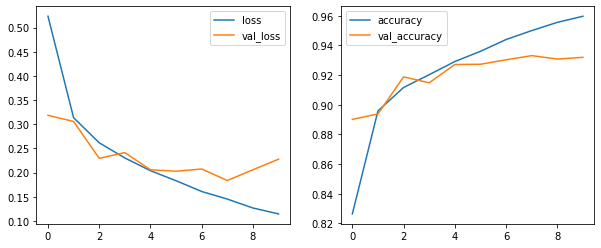

In [12]:
import pandas as pd
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(kind='line', ax=ax[0])
history_df[['accuracy', 'val_accuracy']].plot(kind='line', ax=ax[1]);


#Test data accuracy

In [13]:
test_images_3ch_scaled = test_images_3ch / 255.
predictions = model.predict(test_images_3ch_scaled)
predictions[:5]

array([[8.2340867e-10, 2.8423059e-09, 2.0353642e-10, 5.0417581e-09,
        4.4183140e-10, 2.5759527e-07, 9.0209801e-10, 1.1363073e-05,
        1.3139400e-09, 9.9998832e-01],
       [2.4492384e-04, 5.2904752e-06, 9.9845862e-01, 2.3523331e-05,
        5.6046224e-04, 2.1584758e-05, 6.6686596e-04, 9.2018054e-06,
        6.5140521e-06, 2.9754356e-06],
       [1.3240979e-11, 1.0000000e+00, 2.7550812e-11, 1.3596733e-09,
        1.4097771e-11, 3.4155168e-11, 5.0390820e-11, 1.3885454e-11,
        3.7343105e-13, 1.0608974e-10],
       [9.7635571e-09, 9.9999964e-01, 1.6221936e-08, 3.1688836e-07,
        7.5511704e-09, 1.3278602e-08, 2.6905701e-08, 8.8272527e-09,
        5.8504795e-10, 3.3598564e-08],
       [4.9692589e-01, 7.8504533e-04, 1.2435036e-02, 5.7563242e-03,
        3.6659278e-03, 2.6308002e-03, 4.7291115e-01, 1.2741705e-03,
        2.1356090e-03, 1.4800023e-03]], dtype=float32)

In [14]:
prediction_labels = np.argmax(predictions, axis=1)
prediction_labels[:5]

array([9, 2, 1, 1, 0])

In [16]:
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

print(classification_report(test_labels, prediction_labels, target_names=class_names))
pd.DataFrame(confusion_matrix(test_labels, prediction_labels), index=class_names, columns=class_names)

              precision    recall  f1-score   support

 T-shirt/top       0.87      0.89      0.88      1000
     Trouser       0.99      0.99      0.99      1000
    Pullover       0.88      0.92      0.90      1000
       Dress       0.92      0.93      0.93      1000
        Coat       0.87      0.91      0.89      1000
      Sandal       0.99      0.98      0.99      1000
       Shirt       0.84      0.74      0.79      1000
     Sneaker       0.98      0.97      0.97      1000
         Bag       0.99      0.99      0.99      1000
  Ankle boot       0.96      0.98      0.97      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
T-shirt/top,888,3,14,25,1,0,65,0,4,0
Trouser,2,990,0,6,0,0,1,0,1,0
Pullover,14,1,915,7,33,0,30,0,0,0
Dress,11,4,11,929,24,0,17,0,1,3
Coat,3,1,42,14,909,0,30,0,1,0
Sandal,0,0,0,0,0,983,0,11,0,6
Shirt,100,2,54,26,72,0,742,0,4,0
Sneaker,0,0,0,0,0,4,0,966,0,30
Bag,1,0,1,1,1,1,0,0,994,1
Ankle boot,0,0,0,0,0,2,1,13,0,984


In [17]:
print(test_labels[:100])

[9 2 1 1 6 1 4 6 5 7 4 5 7 3 4 1 2 4 8 0 2 5 7 9 1 4 6 0 9 3 8 8 3 3 8 0 7
 5 7 9 6 1 3 7 6 7 2 1 2 2 4 4 5 8 2 2 8 4 8 0 7 7 8 5 1 1 2 3 9 8 7 0 2 6
 2 3 1 2 8 4 1 8 5 9 5 0 3 2 0 6 5 3 6 7 1 8 0 1 4 2]


##F1 score is 0.93